In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

data_path = os.path.join(os.path.curdir,'data')
print(os.getcwd())
general_data_brute = pd.read_csv(os.path.join(data_path,'general_data.csv'))
in_time_brute = pd.read_csv(os.path.join(data_path, 'in_time.csv'))
out_time_brute = pd.read_csv(os.path.join(data_path, 'out_time.csv'))
manager_survey_data_brute = pd.read_csv(os.path.join(data_path, 'manager_survey_data.csv'))
employee_survey_data_brute = pd.read_csv(os.path.join(data_path, 'employee_survey_data.csv'))



c:\Users\Nazim\Documents\Dev\HumanForYou


In [2]:
general_data_brute.head()

,Age,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeID,Gender,...,NumCompaniesWorked,Over18,PercentSalaryHike,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager
0,51,No,Travel_Rarely,Sales,6,2,Life Sciences,1,1,Female,...,1.0,Y,11,8,0,1.0,6,1,0,0
1,31,Yes,Travel_Frequently,Research & Development,10,1,Life Sciences,1,2,Female,...,0.0,Y,23,8,1,6.0,3,5,1,4
2,32,No,Travel_Frequently,Research & Development,17,4,Other,1,3,Male,...,1.0,Y,15,8,3,5.0,2,5,0,3
3,38,No,Non-Travel,Research & Development,2,5,Life Sciences,1,4,Male,...,3.0,Y,11,8,3,13.0,5,8,7,5
4,32,No,Travel_Rarely,Research & Development,10,1,Medical,1,5,Male,...,4.0,Y,12,8,2,9.0,2,6,0,4


In [3]:
general_data_brute.describe()

,Age,DistanceFromHome,Education,EmployeeCount,EmployeeID,JobLevel,MonthlyIncome,NumCompaniesWorked,PercentSalaryHike,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager
count,4410.000000,4410.000000,4410.000000,4410.0,4410.000000,4410.000000,4410.000000,4391.000000,4410.000000,4410.0,4410.000000,4401.000000,4410.000000,4410.000000,4410.000000,4410.000000
mean,36.923810,9.192517,2.912925,1.0,2205.500000,2.063946,65029.312925,2.694830,15.209524,8.0,0.793878,11.279936,2.799320,7.008163,2.187755,4.123129
std,9.133301,8.105026,1.023933,0.0,1273.201673,1.106689,47068.888559,2.498887,3.659108,0.0,0.851883,7.782222,1.288978,6.125135,3.221699,3.567327
min,18.000000,1.000000,1.000000,1.0,1.000000,1.000000,10090.000000,0.000000,11.000000,8.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,30.000000,2.000000,2.000000,1.0,1103.250000,1.000000,29110.000000,1.000000,12.000000,8.0,0.000000,6.000000,2.000000,3.000000,0.000000,2.000000
50%,36.000000,7.000000,3.000000,1.0,2205.500000,2.000000,49190.000000,2.000000,14.000000,8.0,1.000000,10.000000,3.000000,5.000000,1.000000,3.000000
75%,43.000000,14.000000,4.000000,1.0,3307.750000,3.000000,83800.000000,4.000000,18.000000,8.0,1.000000,15.000000,3.000000,9.000000,3.000000,7.000000
max,60.000000,29.000000,5.000000,1.0,4410.000000,5.000000,199990.000000,9.000000,25.000000,8.0,3.000000,40.000000,6.000000,40.000000,15.000000,17.000000


In [4]:
general_data_brute.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4410 entries, 0 to 4409
Data columns (total 24 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Age                      4410 non-null   int64  
 1   Attrition                4410 non-null   object 
 2   BusinessTravel           4410 non-null   object 
 3   Department               4410 non-null   object 
 4   DistanceFromHome         4410 non-null   int64  
 5   Education                4410 non-null   int64  
 6   EducationField           4410 non-null   object 
 7   EmployeeCount            4410 non-null   int64  
 8   EmployeeID               4410 non-null   int64  
 9   Gender                   4410 non-null   object 
 10  JobLevel                 4410 non-null   int64  
 11  JobRole                  4410 non-null   object 
 12  MaritalStatus            4410 non-null   object 
 13  MonthlyIncome            4410 non-null   int64  
 14  NumCompaniesWorked      

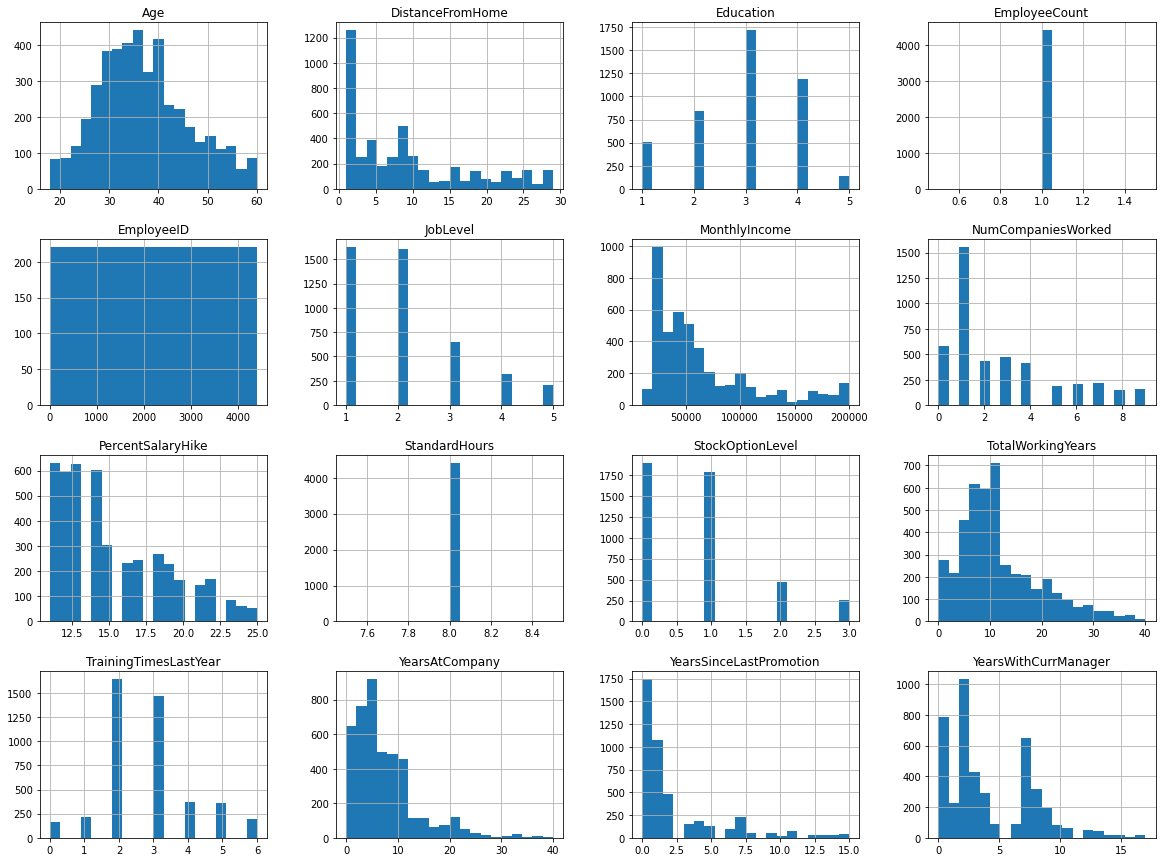

In [5]:
general_data_brute.hist(bins=20, figsize=(20, 15))
plt.show()

In [6]:
manager_survey_data_brute.head()

,EmployeeID,JobInvolvement,PerformanceRating
0,1,3,3
1,2,2,4
2,3,3,3
3,4,2,3
4,5,3,3


In [7]:
manager_survey_data_brute.describe()

,EmployeeID,JobInvolvement,PerformanceRating
count,4410.000000,4410.000000,4410.000000
mean,2205.500000,2.729932,3.153741
std,1273.201673,0.711400,0.360742
min,1.000000,1.000000,3.000000
25%,1103.250000,2.000000,3.000000
50%,2205.500000,3.000000,3.000000
75%,3307.750000,3.000000,3.000000
max,4410.000000,4.000000,4.000000


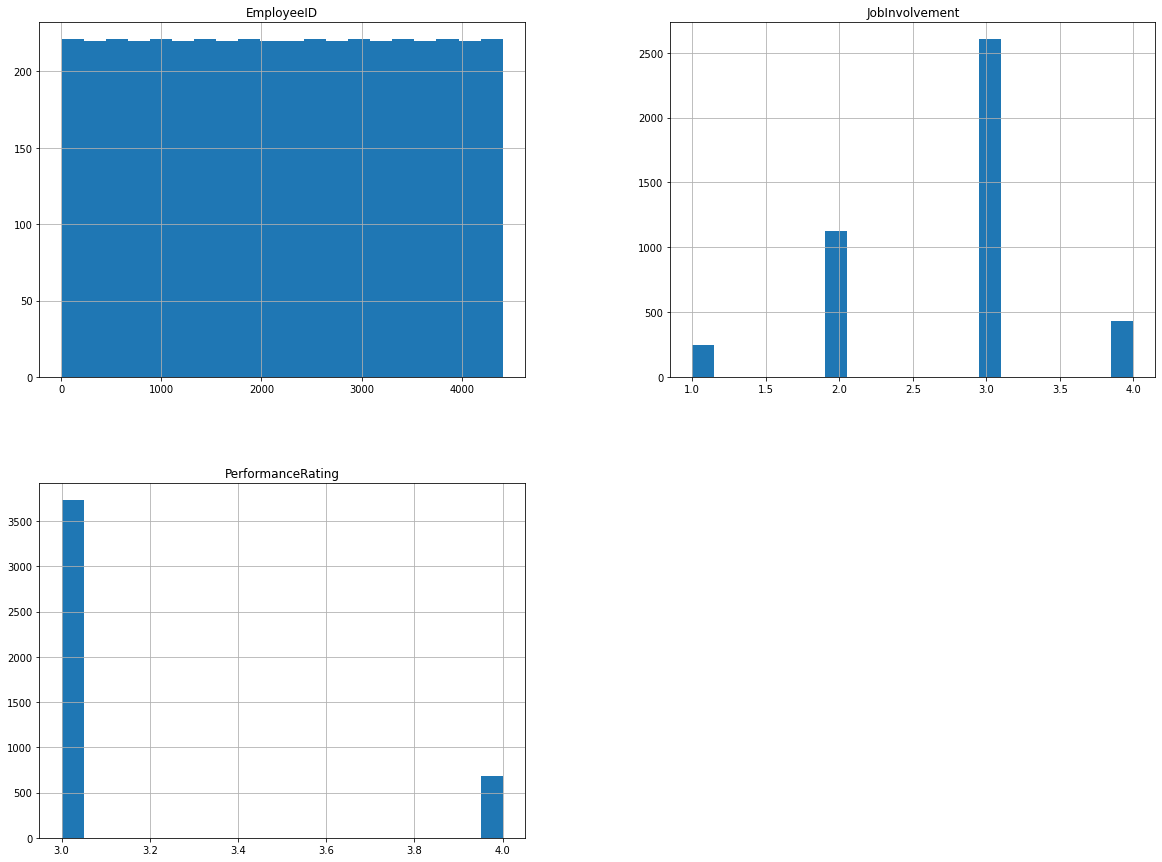

In [8]:
manager_survey_data_brute.hist(bins=20, figsize=(20, 15))
plt.show()


In [9]:
employee_survey_data_brute.head()


,EmployeeID,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance
0,1,3.0,4.0,2.0
1,2,3.0,2.0,4.0
2,3,2.0,2.0,1.0
3,4,4.0,4.0,3.0
4,5,4.0,1.0,3.0


In [10]:
employee_survey_data_brute.describe()

,EmployeeID,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance
count,4410.000000,4385.000000,4390.000000,4372.000000
mean,2205.500000,2.723603,2.728246,2.761436
std,1273.201673,1.092756,1.101253,0.706245
min,1.000000,1.000000,1.000000,1.000000
25%,1103.250000,2.000000,2.000000,2.000000
50%,2205.500000,3.000000,3.000000,3.000000
75%,3307.750000,4.000000,4.000000,3.000000
max,4410.000000,4.000000,4.000000,4.000000


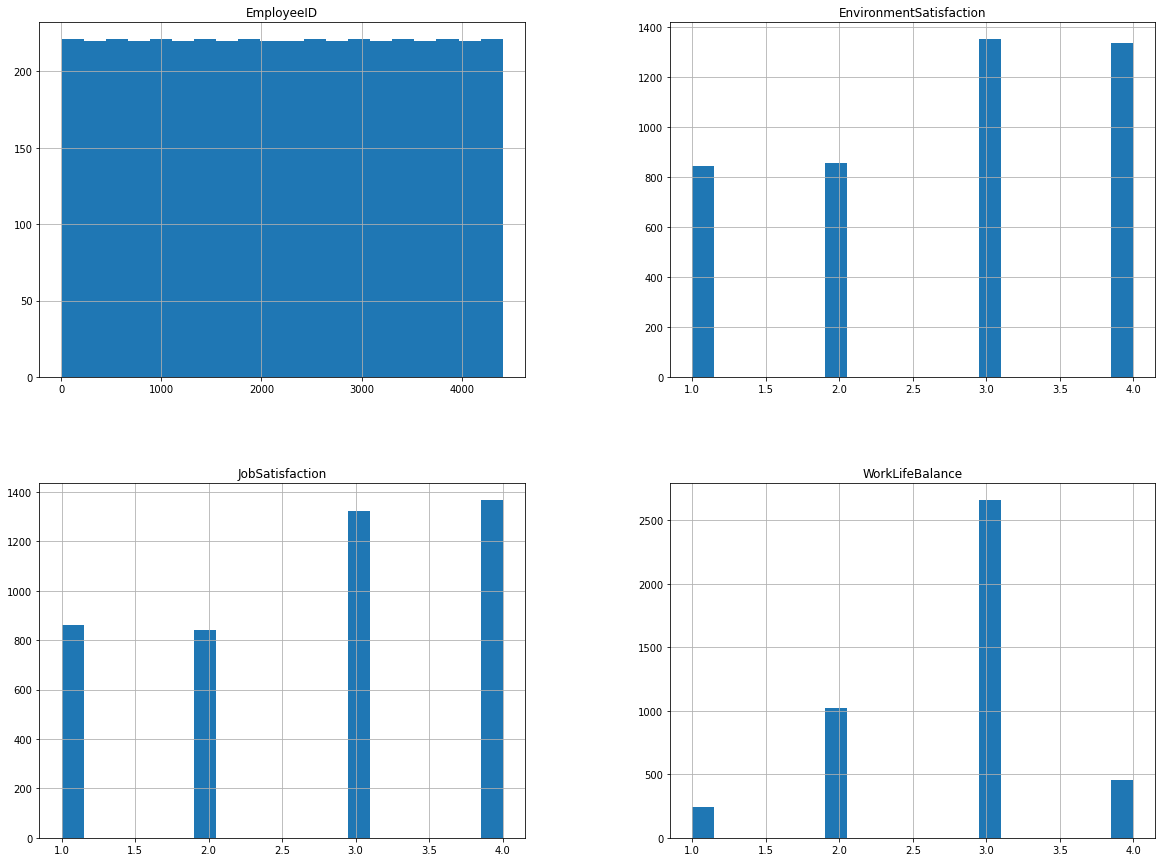

In [11]:
employee_survey_data_brute.hist(bins=20, figsize=(20, 15))
plt.show()

collone a ajouter : 
    abscences
    heures supp
    

In [12]:
general_data = general_data_brute.drop('Over18',axis=1)
general_data = general_data.drop('StandardHours',axis=1)

In [13]:
general_data.head()

,Age,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeID,Gender,...,MaritalStatus,MonthlyIncome,NumCompaniesWorked,PercentSalaryHike,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager
0,51,No,Travel_Rarely,Sales,6,2,Life Sciences,1,1,Female,...,Married,131160,1.0,11,0,1.0,6,1,0,0
1,31,Yes,Travel_Frequently,Research & Development,10,1,Life Sciences,1,2,Female,...,Single,41890,0.0,23,1,6.0,3,5,1,4
2,32,No,Travel_Frequently,Research & Development,17,4,Other,1,3,Male,...,Married,193280,1.0,15,3,5.0,2,5,0,3
3,38,No,Non-Travel,Research & Development,2,5,Life Sciences,1,4,Male,...,Married,83210,3.0,11,3,13.0,5,8,7,5
4,32,No,Travel_Rarely,Research & Development,10,1,Medical,1,5,Male,...,Single,23420,4.0,12,2,9.0,2,6,0,4


In [14]:
in_time_brute.head()

,Unnamed: 0,2015-01-01,2015-01-02,2015-01-05,2015-01-06,2015-01-07,2015-01-08,2015-01-09,2015-01-12,2015-01-13,...,2015-12-18,2015-12-21,2015-12-22,2015-12-23,2015-12-24,2015-12-25,2015-12-28,2015-12-29,2015-12-30,2015-12-31
0,1,NaN,2015-01-02 09:43:45,2015-01-05 10:08:48,2015-01-06 09:54:26,2015-01-07 09:34:31,2015-01-08 09:51:09,2015-01-09 10:09:25,2015-01-12 09:42:53,2015-01-13 10:13:06,...,NaN,2015-12-21 09:55:29,2015-12-22 10:04:06,2015-12-23 10:14:27,2015-12-24 10:11:35,NaN,2015-12-28 10:13:41,2015-12-29 10:03:36,2015-12-30 09:54:12,2015-12-31 10:12:44
1,2,NaN,2015-01-02 10:15:44,2015-01-05 10:21:05,NaN,2015-01-07 09:45:17,2015-01-08 10:09:04,2015-01-09 09:43:26,2015-01-12 10:00:07,2015-01-13 10:43:29,...,2015-12-18 10:37:17,2015-12-21 09:49:02,2015-12-22 10:33:51,2015-12-23 10:12:10,NaN,NaN,2015-12-28 09:31:45,2015-12-29 09:55:49,2015-12-30 10:32:25,2015-12-31 09:27:20
2,3,NaN,2015-01-02 10:17:41,2015-01-05 09:50:50,2015-01-06 10:14:13,2015-01-07 09:47:27,2015-01-08 10:03:40,2015-01-09 10:05:49,2015-01-12 10:03:47,2015-01-13 10:21:26,...,2015-12-18 10:15:14,2015-12-21 10:10:28,2015-12-22 09:44:44,2015-12-23 10:15:54,2015-12-24 10:07:26,NaN,2015-12-28 09:42:05,2015-12-29 09:43:36,2015-12-30 09:34:05,2015-12-31 10:28:39
3,4,NaN,2015-01-02 10:05:06,2015-01-05 09:56:32,2015-01-06 10:11:07,2015-01-07 09:37:30,2015-01-08 10:02:08,2015-01-09 10:08:12,2015-01-12 10:13:42,2015-01-13 09:53:22,...,2015-12-18 10:17:38,2015-12-21 09:58:21,2015-12-22 10:04:25,2015-12-23 10:11:46,2015-12-24 09:43:15,NaN,2015-12-28 09:52:44,2015-12-29 09:33:16,2015-12-30 10:18:12,2015-12-31 10:01:15
4,5,NaN,2015-01-02 10:28:17,2015-01-05 09:49:58,2015-01-06 09:45:28,2015-01-07 09:49:37,2015-01-08 10:19:44,2015-01-09 10:00:50,2015-01-12 10:29:27,2015-01-13 09:59:32,...,2015-12-18 09:58:35,2015-12-21 10:03:41,2015-12-22 10:10:30,2015-12-23 10:13:36,2015-12-24 09:44:24,NaN,2015-12-28 10:05:15,2015-12-29 10:30:53,2015-12-30 09:18:21,2015-12-31 09:41:09


In [31]:
out_time = out_time_brute.copy()
out_time['employee_id'] = out_time_brute[out_time_brute.columns[0]]
out_time.drop(out_time_brute.columns[0],axis=1)

,2015-01-01,2015-01-02,2015-01-05,2015-01-06,2015-01-07,2015-01-08,2015-01-09,2015-01-12,2015-01-13,2015-01-14,...,2015-12-21,2015-12-22,2015-12-23,2015-12-24,2015-12-25,2015-12-28,2015-12-29,2015-12-30,2015-12-31,employee_id
0,NaN,2015-01-02 16:56:15,2015-01-05 17:20:11,2015-01-06 17:19:05,2015-01-07 16:34:55,2015-01-08 17:08:32,2015-01-09 17:38:29,2015-01-12 16:58:39,2015-01-13 18:02:58,NaN,...,2015-12-21 17:15:50,2015-12-22 17:27:51,2015-12-23 16:44:44,2015-12-24 17:47:22,NaN,2015-12-28 18:00:07,2015-12-29 17:22:30,2015-12-30 17:40:56,2015-12-31 17:17:33,1
1,NaN,2015-01-02 18:22:17,2015-01-05 17:48:22,NaN,2015-01-07 17:09:06,2015-01-08 17:34:04,2015-01-09 16:52:29,2015-01-12 17:36:48,2015-01-13 18:00:13,NaN,...,2015-12-21 17:34:16,2015-12-22 18:16:35,2015-12-23 17:38:18,NaN,NaN,2015-12-28 17:08:38,2015-12-29 17:54:46,2015-12-30 18:31:35,2015-12-31 17:40:58,2
2,NaN,2015-01-02 16:59:14,2015-01-05 17:06:46,2015-01-06 16:38:32,2015-01-07 16:33:21,2015-01-08 17:24:22,2015-01-09 16:57:30,2015-01-12 17:28:54,2015-01-13 17:21:25,NaN,...,2015-12-21 17:20:17,2015-12-22 16:32:50,2015-12-23 16:59:43,2015-12-24 16:58:25,NaN,2015-12-28 16:43:31,2015-12-29 17:09:56,2015-12-30 17:06:25,2015-12-31 17:15:50,3
3,NaN,2015-01-02 17:25:24,2015-01-05 17:14:03,2015-01-06 17:07:42,2015-01-07 16:32:40,2015-01-08 16:53:11,2015-01-09 17:19:47,2015-01-12 17:13:37,2015-01-13 17:11:45,NaN,...,2015-12-21 16:49:09,2015-12-22 17:24:00,2015-12-23 17:36:35,2015-12-24 16:48:21,NaN,2015-12-28 17:19:34,2015-12-29 16:58:16,2015-12-30 17:40:11,2015-12-31 17:09:14,4
4,NaN,2015-01-02 18:31:37,2015-01-05 17:49:15,2015-01-06 17:26:25,2015-01-07 17:37:59,2015-01-08 17:59:28,2015-01-09 17:44:08,2015-01-12 18:51:21,2015-01-13 18:14:58,NaN,...,2015-12-21 17:43:35,2015-12-22 18:07:57,2015-12-23 18:00:49,2015-12-24 17:59:22,NaN,2015-12-28 17:44:59,2015-12-29 18:47:00,2015-12-30 17:15:33,2015-12-31 17:42:14,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4405,NaN,2015-01-02 17:27:37,2015-01-05 19:08:20,2015-01-06 18:50:49,2015-01-07 18:57:40,2015-01-08 17:58:31,2015-01-09 18:06:15,2015-01-12 17:58:48,2015-01-13 18:10:35,NaN,...,2015-12-21 18:35:06,2015-12-22 18:33:44,2015-12-23 18:40:56,2015-12-24 18:21:29,NaN,2015-12-28 18:44:35,2015-12-29 19:14:38,2015-12-30 18:24:56,2015-12-31 18:30:41,4406
4406,NaN,2015-01-02 16:19:01,NaN,2015-01-06 15:07:37,2015-01-07 15:25:50,2015-01-08 16:12:33,2015-01-09 15:26:56,2015-01-12 16:10:42,2015-01-13 16:22:43,NaN,...,2015-12-21 15:31:14,2015-12-22 15:45:59,2015-12-23 16:38:59,2015-12-24 15:47:15,NaN,2015-12-28 15:34:34,2015-12-29 16:47:02,2015-12-30 16:03:17,2015-12-31 16:18:39,4407
4407,NaN,2015-01-02 17:17:35,2015-01-05 17:08:07,2015-01-06 17:27:46,2015-01-07 18:27:22,2015-01-08 17:05:25,2015-01-09 17:02:57,2015-01-12 17:35:45,2015-01-13 17:15:52,NaN,...,2015-12-21 17:43:05,2015-12-22 17:47:23,2015-12-23 17:43:37,2015-12-24 17:20:12,NaN,2015-12-28 17:43:28,NaN,2015-12-30 17:48:14,2015-12-31 18:08:55,4408
4408,NaN,2015-01-02 19:48:37,2015-01-05 19:37:40,2015-01-06 20:00:08,2015-01-07 19:35:59,2015-01-08 18:55:13,NaN,2015-01-12 19:18:17,2015-01-13 19:24:02,NaN,...,2015-12-21 19:21:35,2015-12-22 19:32:40,2015-12-23 18:57:00,2015-12-24 19:37:57,NaN,2015-12-28 19:58:36,2015-12-29 18:55:26,2015-12-30 19:37:22,2015-12-31 19:33:45,4409


In [15]:
in_time = in_time_brute.copy()
in_time['employee_id'] = in_time_brute[in_time_brute.columns[0]]
in_time.drop(in_time_brute.columns[0],axis=1)


,2015-01-01,2015-01-02,2015-01-05,2015-01-06,2015-01-07,2015-01-08,2015-01-09,2015-01-12,2015-01-13,2015-01-14,...,2015-12-21,2015-12-22,2015-12-23,2015-12-24,2015-12-25,2015-12-28,2015-12-29,2015-12-30,2015-12-31,employee_id
0,NaN,2015-01-02 09:43:45,2015-01-05 10:08:48,2015-01-06 09:54:26,2015-01-07 09:34:31,2015-01-08 09:51:09,2015-01-09 10:09:25,2015-01-12 09:42:53,2015-01-13 10:13:06,NaN,...,2015-12-21 09:55:29,2015-12-22 10:04:06,2015-12-23 10:14:27,2015-12-24 10:11:35,NaN,2015-12-28 10:13:41,2015-12-29 10:03:36,2015-12-30 09:54:12,2015-12-31 10:12:44,1
1,NaN,2015-01-02 10:15:44,2015-01-05 10:21:05,NaN,2015-01-07 09:45:17,2015-01-08 10:09:04,2015-01-09 09:43:26,2015-01-12 10:00:07,2015-01-13 10:43:29,NaN,...,2015-12-21 09:49:02,2015-12-22 10:33:51,2015-12-23 10:12:10,NaN,NaN,2015-12-28 09:31:45,2015-12-29 09:55:49,2015-12-30 10:32:25,2015-12-31 09:27:20,2
2,NaN,2015-01-02 10:17:41,2015-01-05 09:50:50,2015-01-06 10:14:13,2015-01-07 09:47:27,2015-01-08 10:03:40,2015-01-09 10:05:49,2015-01-12 10:03:47,2015-01-13 10:21:26,NaN,...,2015-12-21 10:10:28,2015-12-22 09:44:44,2015-12-23 10:15:54,2015-12-24 10:07:26,NaN,2015-12-28 09:42:05,2015-12-29 09:43:36,2015-12-30 09:34:05,2015-12-31 10:28:39,3
3,NaN,2015-01-02 10:05:06,2015-01-05 09:56:32,2015-01-06 10:11:07,2015-01-07 09:37:30,2015-01-08 10:02:08,2015-01-09 10:08:12,2015-01-12 10:13:42,2015-01-13 09:53:22,NaN,...,2015-12-21 09:58:21,2015-12-22 10:04:25,2015-12-23 10:11:46,2015-12-24 09:43:15,NaN,2015-12-28 09:52:44,2015-12-29 09:33:16,2015-12-30 10:18:12,2015-12-31 10:01:15,4
4,NaN,2015-01-02 10:28:17,2015-01-05 09:49:58,2015-01-06 09:45:28,2015-01-07 09:49:37,2015-01-08 10:19:44,2015-01-09 10:00:50,2015-01-12 10:29:27,2015-01-13 09:59:32,NaN,...,2015-12-21 10:03:41,2015-12-22 10:10:30,2015-12-23 10:13:36,2015-12-24 09:44:24,NaN,2015-12-28 10:05:15,2015-12-29 10:30:53,2015-12-30 09:18:21,2015-12-31 09:41:09,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4405,NaN,2015-01-02 09:20:32,2015-01-05 10:17:53,2015-01-06 10:26:51,2015-01-07 10:06:58,2015-01-08 09:45:06,2015-01-09 09:49:24,2015-01-12 09:37:10,2015-01-13 09:25:02,NaN,...,2015-12-21 10:25:25,2015-12-22 10:16:11,2015-12-23 10:04:40,2015-12-24 09:45:40,NaN,2015-12-28 10:15:39,2015-12-29 10:10:09,2015-12-30 09:28:19,2015-12-31 10:00:12,4406
4406,NaN,2015-01-02 10:03:41,NaN,2015-01-06 09:44:00,2015-01-07 09:42:10,2015-01-08 10:00:57,2015-01-09 09:44:04,2015-01-12 10:07:32,2015-01-13 10:05:11,NaN,...,2015-12-21 09:41:24,2015-12-22 09:50:30,2015-12-23 10:32:21,2015-12-24 09:47:41,NaN,2015-12-28 09:54:23,2015-12-29 10:13:32,2015-12-30 10:21:09,2015-12-31 10:09:48,4407
4407,NaN,2015-01-02 10:01:01,2015-01-05 09:33:00,2015-01-06 09:49:17,2015-01-07 10:28:12,2015-01-08 09:47:38,2015-01-09 10:01:03,2015-01-12 09:49:12,2015-01-13 09:47:10,NaN,...,2015-12-21 09:51:07,2015-12-22 10:02:10,2015-12-23 09:58:29,2015-12-24 09:56:05,NaN,2015-12-28 09:59:24,NaN,2015-12-30 10:02:36,2015-12-31 10:03:30,4408
4408,NaN,2015-01-02 10:17:05,2015-01-05 10:02:27,2015-01-06 10:12:50,2015-01-07 10:12:31,2015-01-08 09:42:57,NaN,2015-01-12 10:00:38,2015-01-13 09:48:03,NaN,...,2015-12-21 10:01:08,2015-12-22 10:10:19,2015-12-23 09:42:30,2015-12-24 09:56:05,NaN,2015-12-28 09:55:25,2015-12-29 09:54:42,2015-12-30 10:15:44,2015-12-31 09:56:47,4409


In [49]:
# count work hours for each employee
from datetime import datetime, timedelta
employees_hours = []
additional_hours = []
for index, row in general_data.iterrows():
    employee_id = row['EmployeeID']
    in_time_employee = in_time[in_time['employee_id']
                               == employee_id].values[0]
    out_time_employee = out_time[out_time['employee_id']
                                 == employee_id].values[0]
    
    out_time_employee = out_time_employee[1:-1]
    in_time_employee = in_time_employee[1:-1]
    
    now = datetime.now()
    in_time_employee = np.array([datetime.strptime(
        x, '%Y-%m-%d %H:%M:%S') if not pd.isna(x) else now for x in in_time_employee])
    out_time_employee = np.array([datetime.strptime(
        x, '%Y-%m-%d %H:%M:%S') if not pd.isna(x) else now for x in out_time_employee])
    
    employee_hours = out_time_employee - in_time_employee
    employee_hours = [x.total_seconds() for x in employee_hours]
    employee_hours = sum(employee_hours)
    employees_hours.append(employee_hours/(60**2))
    nb_day = len(out_time_employee)
    additional_hour = ((8*nb_day)-employee_hours/(60**2))
    if(additional_hour < 0) : additional_hour = 0
    additional_hours.append(additional_hour)
general_data['worked_hour'] = employees_hours
general_data['additional_hour'] = additional_hours



In [47]:
general_data['worked_hour']

0       1710.686944
1       1821.676667
2       1697.204167
3       1690.514444
4       1961.512778
           ...     
4405    2070.913333
4406    1468.401944
4407    1780.231944
4408    2287.715278
4409    1621.435833
Name: worked_hour, Length: 4410, dtype: float64

In [50]:
general_data.describe()


,Age,DistanceFromHome,Education,EmployeeCount,EmployeeID,JobLevel,MonthlyIncome,NumCompaniesWorked,PercentSalaryHike,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager,worked_hour,additional_hour
count,4410.000000,4410.000000,4410.000000,4410.0,4410.000000,4410.000000,4410.000000,4391.000000,4410.000000,4410.000000,4401.000000,4410.000000,4410.000000,4410.000000,4410.000000,4410.000000,4410.000000
mean,36.923810,9.192517,2.912925,1.0,2205.500000,2.063946,65029.312925,2.694830,15.209524,0.793878,11.279936,2.799320,7.008163,2.187755,4.123129,1821.276283,325.243391
std,9.133301,8.105026,1.023933,0.0,1273.201673,1.106689,47068.888559,2.498887,3.659108,0.851883,7.782222,1.288978,6.125135,3.221699,3.567327,331.361528,229.703434
min,18.000000,1.000000,1.000000,1.0,1.000000,1.000000,10090.000000,0.000000,11.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1348.803056,0.000000
25%,30.000000,2.000000,2.000000,1.0,1103.250000,1.000000,29110.000000,1.000000,12.000000,0.000000,6.000000,2.000000,3.000000,0.000000,2.000000,1563.572500,120.704653
50%,36.000000,7.000000,3.000000,1.0,2205.500000,2.000000,49190.000000,2.000000,14.000000,1.000000,10.000000,3.000000,5.000000,1.000000,3.000000,1745.782222,342.217778
75%,43.000000,14.000000,4.000000,1.0,3307.750000,3.000000,83800.000000,4.000000,18.000000,1.000000,15.000000,3.000000,9.000000,3.000000,7.000000,1967.295347,524.427500
max,60.000000,29.000000,5.000000,1.0,4410.000000,5.000000,199990.000000,9.000000,25.000000,3.000000,40.000000,6.000000,40.000000,15.000000,17.000000,2723.378056,739.196944
